In [67]:
# Figure 1 

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(ggridges)
library(ggpubr)
library(qs)
library(factoextra)


# data
# meta_raw <- read.table('raw/FELINE_C1_raw_singler_metadata.txt', sep='\t') # combined raw metadata of FELINE-C1. Generated by IB. Not used in this analysis. 

# hpca_anno_raw <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/raw/SingleR/hpca/FELINE_C1_hpca_singleR_annotations.txt', sep='auto'))[, -1] # hpca singleR annotations FELINE-C1
# metadata_post_filter <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/post-filter/FEL001046_scRNA.metadata_JF.txt', sep='auto')) # Jinfeng's high quality metadata 
meta_sub_LQ <- fread('metadata_subsample_LQ.txt', sep='\t', data.table=F) # low quality subsample metadata
meta_sub_HQ <- fread('metadata_subsample_HQ.txt', sep='\t', data.table=F) # high quality subsample metadata

meta_sub <- bind_rows(meta_sub_HQ[, c('Cell', 'Percent.Mitochondria', 'nCount_RNA', 'nFeature_RNA', 'Annotation', 'Celltype', 'hpca', 'Lineage')], 
meta_sub_LQ[, c('Cell', 'nCount_RNA', 'nFeature_RNA', 'Percent.Mitochondria', 'hpca', 'Lineage')])



[1] 35000    10

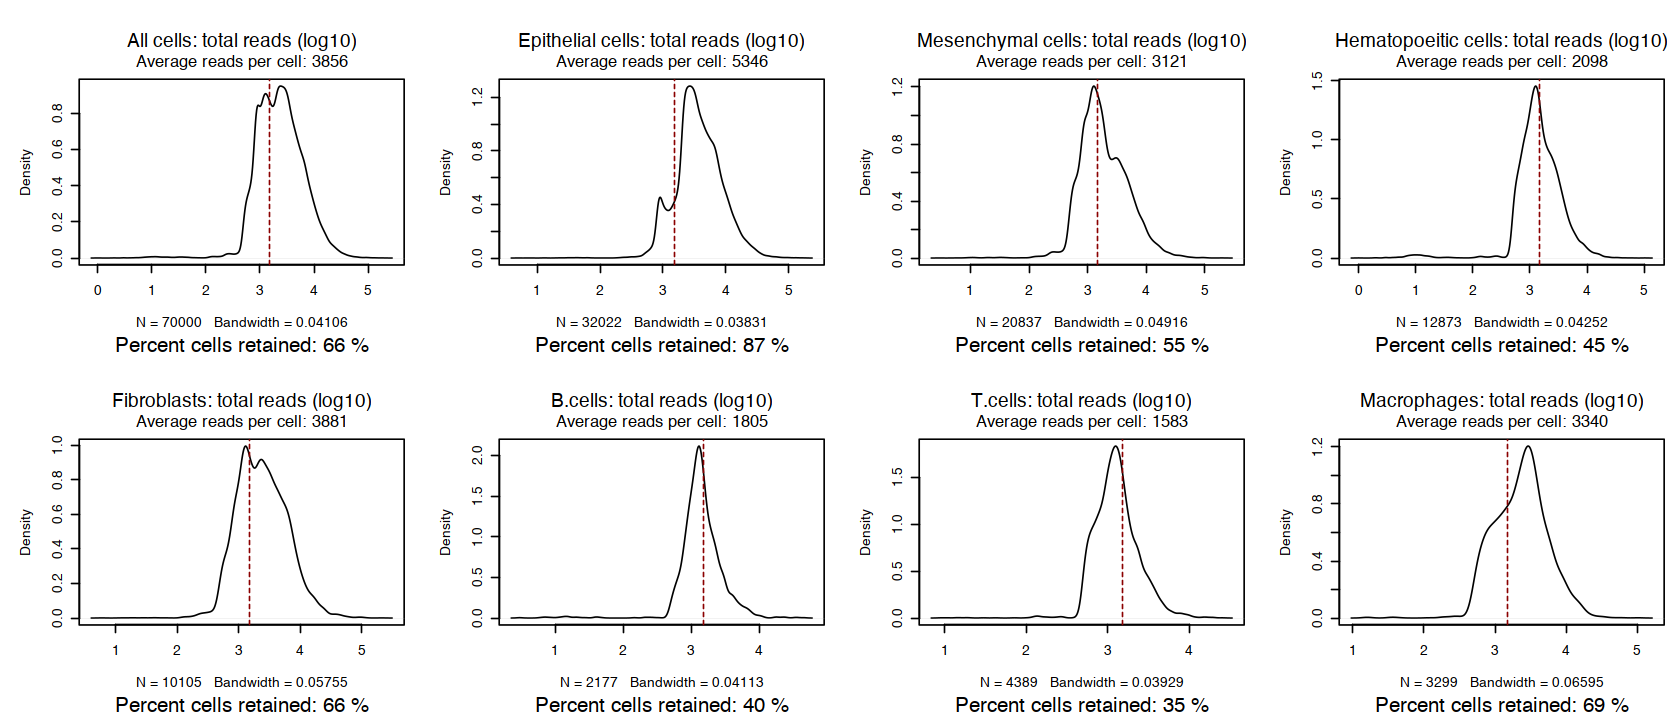

In [68]:
options(repr.plot.width=14, repr.plot.height=6)

## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Stromal_cells")
hem.ind <- which(meta_sub$Lineage == "Immune_cells")

# cell type
tcell.ind <- which( meta_sub$hpca == "T_cells" )
bcell.ind <- which( meta_sub$hpca == "B_cell" )
macro.ind <- which( meta_sub$hpca == "Macrophage")
fibro.ind <- which( meta_sub$hpca == "Fibroblasts")
endo.ind <- which( meta_sub$hpca == "Endothelial_cells")
bcell.ind <- which( meta_sub$hpca == "B_cell")



## setting cut-offs
## JF's cut-off for FELINE_C1: > 1500 UMI. 500 - 7000 genes 
nCount_RNA_cutoff <- 1500
new.nCount_RNA_cutoff <- 400
Expressed.Features_cutoff.min <- 500
Expressed.Features_cutoff.max <- 7000



all.retained <- length(which(meta_sub$nCount_RNA > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA )
epi.retained <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[epi.ind] )
mes.retained <- length(which(meta_sub$nCount_RNA[mes.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[mes.ind] )
hem.retained <- length(which(meta_sub$nCount_RNA[hem.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[hem.ind] )

tcell.retained <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[tcell.ind] )
macro.retained <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[macro.ind] )
fibro.retained <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[fibro.ind] )
endo.retained <- length(which(meta_sub$nCount_RNA[endo.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[endo.ind] )
bcell.retained <- length(which(meta_sub$nCount_RNA[bcell.ind] > nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[bcell.ind] )


# pre.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff))
# post.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[epi.ind] > new.nCount_RNA_cutoff))

# pre.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff))
# post.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[tcell.ind] > new.nCount_RNA_cutoff))

# pre.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff))
# post.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[macro.ind] > new.nCount_RNA_cutoff))

# pre.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff))
# post.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[fibro.ind] > new.nCount_RNA_cutoff))
## Plot number of reads and genes by Cell type. Epithelial cells are used as a reference 

title.size <- 1.4
lab.size <- 1.0
sub.size <- 1.4

par(mfrow=c(2,4), mar=c(6,5,5,1))


plot(main = "All cells: total reads (log10)", density(log10(meta_sub$nCount_RNA)), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*all.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA)) ),)  # subtitle

plot(main = "Epithelial cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[epi.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*epi.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[epi.ind])) ),)  # subtitle

plot(main = "Stromal cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[mes.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*mes.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[mes.ind])) ),)  # subtitle

plot(main = "Immune cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[hem.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*hem.retained),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[hem.ind])) ),)  # subtitle

plot(main = "Fibroblasts: total reads (log10)", density(log10(meta_sub$nCount_RNA[fibro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*fibro.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[fibro.ind])) ),)  # subtitle

plot(main = "B.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[bcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*bcell.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[bcell.ind])) ),)  # subtitle

plot(main = "T.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[tcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*tcell.retained ),'%' ))  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[tcell.ind])) ),)  # subtitle

plot(main = "Macrophages: total reads (log10)", density(log10(meta_sub$nCount_RNA[macro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred")
mtext(line= -17.3, adj=0.5, cex=1, paste('Percent cells retained:', round(100*macro.retained ),'%' ),)  # subtitle
mtext(line= 0.7, adj=0.5, cex=0.8, paste('Average reads per cell:', round(mean(meta_sub$nCount_RNA[macro.ind])) ),)  # subtitle



## Add mean annotations 




In [1]:
options(warn=-1) # warnings off

# Figure 2
setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(ggridges)
library(ggpubr)
library(stringr)

# data
# all.perf1 <- paste('non-binary/', list.files(path = "/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_non-binary_Lineage.txt", pattern = "SCNPerformance_*", recursive = TRUE), sep='') # create a list of raw count tables from all batches
# all.perf2 <- paste('floor/', list.files(path = "/Users/ibishara/Desktop/FELINE_C1/SCN/floor/", pattern = "Performance_*", recursive = TRUE), sep='') # create a list of raw count tables from all batches
# all.perf <- c(all.perf1, all.perf2)
# all.perf

all.perf <- list.files(path = "/Users/ibishara/Desktop/FELINE_C1/", pattern = "SCN_Performance*", recursive = FALSE)  # create a list of raw count tables from all batches
perf.list.SCN <- lapply( all.perf, FUN = function(x) {fread(x, sep='auto')})
perf.SCN <- as.data.frame(do.call(rbind, perf.list.SCN))  #join list of tables 


all.perf <- list.files(path = "/Users/ibishara/Desktop/FELINE_C1/", pattern = "SR_Performance*", recursive = FALSE)  # create a list of raw count tables from all batches
perf.list.SR <- lapply( all.perf, FUN = function(x) {fread(x, sep='auto')})
perf.SR <- as.data.frame(do.call(rbind, perf.list.SR))  #join list of tables 

### deployment script
# SCN_Performance_summary_non_binary_Lineage <- fread("/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_non-binary_Lineage.txt", sep='auto')
# SCN_Performance_summary_floor_Lineage <- fread("/Users/ibishara/Desktop/FELINE_C1/SCN_Performance_summary_floor_Lineage.txt", sep='auto')

###

# distribution clean-up
# table_type = reads, genes
# method = floor, non-binary

dist.clean <- function(table_type, method){
        # dist <- fread(paste('SCN_', table_type, '_distribution_', method, '.txt' , sep=''), sep = '\t') # read distribution table 
            if(method == 'floor') {dist <- fread(paste('SCN_', table_type, '_distribution_reads_', method, '_Lineage.txt' , sep=''), sep = '\t') # read distribution table 
            } else if (method == 'poisson'){
            dist <- fread(paste('SCN_', table_type, '_distribution_', method, '.txt' , sep=''), sep = '\t') }# read distribution table 

            ##
            # data clean-up
            dist$V1 <- NULL
            dist <- as.data.frame(t(dist))
            colnames(dist) <- dist[1,]
            dist <- dist[-1,]
            dist <- melt(dist)
        }
# dist.reads_floor <- dist.clean('reads', 'floor')
# dist.genes_floor <- dist.clean('genes', 'floor')
dist.reads_poisson <- dist.clean('reads', 'poisson')
dist.genes_poisson <- dist.clean('genes', 'poisson')
# dist.reads_nonbin <- dist.clean('reads', 'non-binary')
# dist.genes_nonbin <- dist.clean('genes', 'non-binary')

# Calculates mean and median for plot annotations 
summ <- function(x) c(Mean = mean(x), median = median(x))
summ.clean <- function(mat) {
    stats <- aggregate(value ~  variable, mat, summ, simplify = TRUE)
    stats <- cbind(stats[1], round(stats[[2]]))
    return(stats)
}

stat.reads_poisson <- summ.clean(dist.reads_poisson)
stat.genes_poisson <- summ.clean(dist.genes_poisson )
# stat.reads_floor <- summ.clean(dist.reads_floor)
# stat.genes_floor <- summ.clean(dist.genes_floor )
# stat.reads_nonbin <- summ.clean(dist.reads_nonbin)
# stat.genes_nonbin <- summ.clean(dist.genes_nonbin)


Loading required package: ggplot2

No id variables; using all as measure variables

No id variables; using all as measure variables



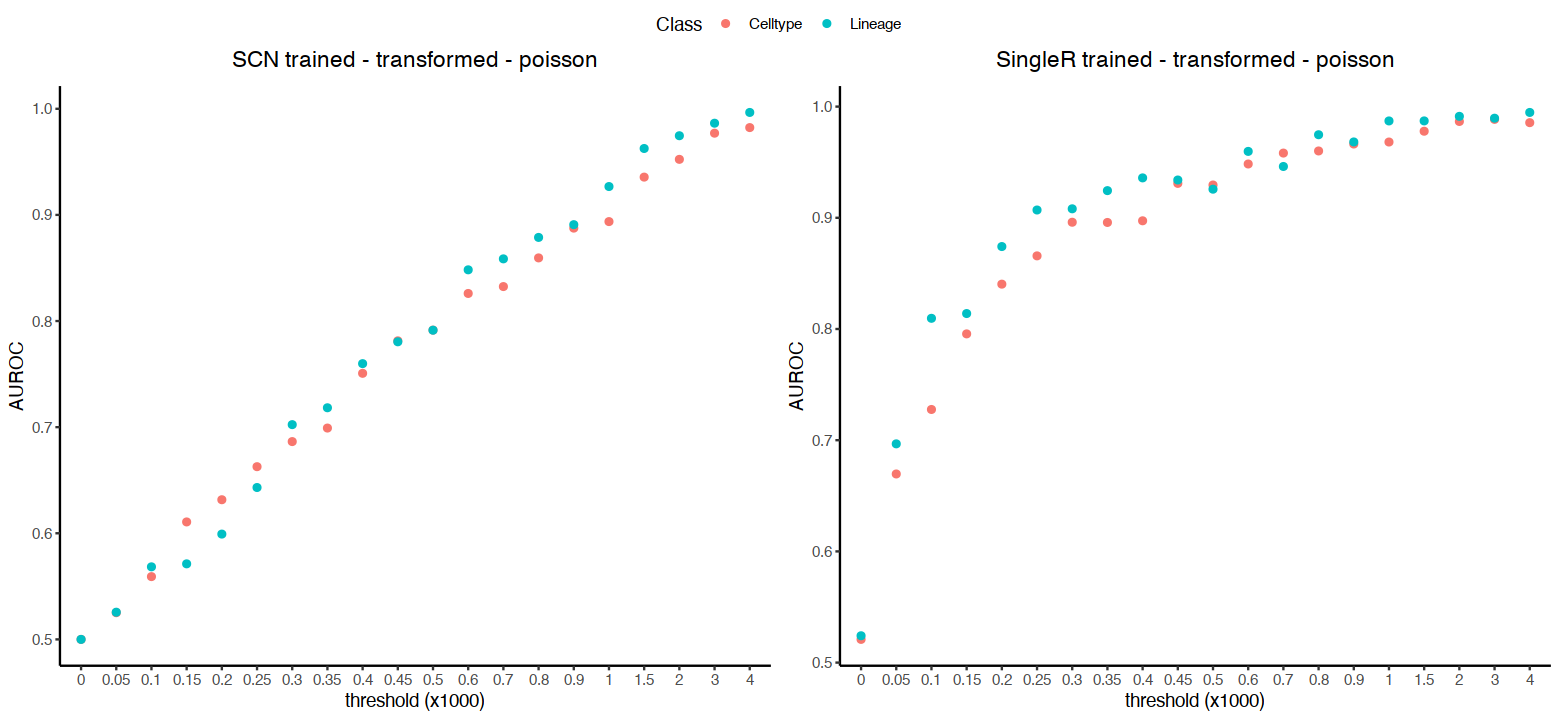

In [45]:


# train = 'SCN', 'SR'
# method = 'floor', 'non-binary'
# function plots the AUC at different thresholds of a 'train' algorithm and transformed by 'method'
AUCplot <- function(train, method) {
    if (train == 'SCN'){ 
        train = perf.SCN
        train.name <- 'SCN trained'

    } else if(train == 'SR') {
        train = perf.SR
        train.name <- 'SingleR trained'
        }

    # AUC plot    
    ggplot(train[train$method == method,], aes(as.factor(threshold), as.numeric(AUC_pROC)  )) + 
                geom_point(aes(color = as.factor(class))) + 
                ggtitle(paste(train.name, "transformed", method, sep =' - ')) +
                xlab("threshold (x1000)") + ylab("AUROC")+ labs(color='Class')  +
                theme_classic() + 
                theme(plot.title = element_text(vjust = 2, hjust = 0.5)) # center plot title

}



# summary plots
plot1 <- AUCplot('SCN', 'poisson')
plot2 <- AUCplot('SR', 'poisson')


# plot3 <- plotf('SCN', 'non-binary')
# plot4 <- plotf('SR', 'non-binary')

# pdf('performance_perf.SCNary_400_400cells.pdf')
spacer <- NULL
ggarrange(grobs = plot1, plot2, ncol = 2, nrow = 1, heights=c(50), widths = c(50,  50), common.legend = TRUE)

#dev.off()
options(repr.plot.width=13, repr.plot.height=6)


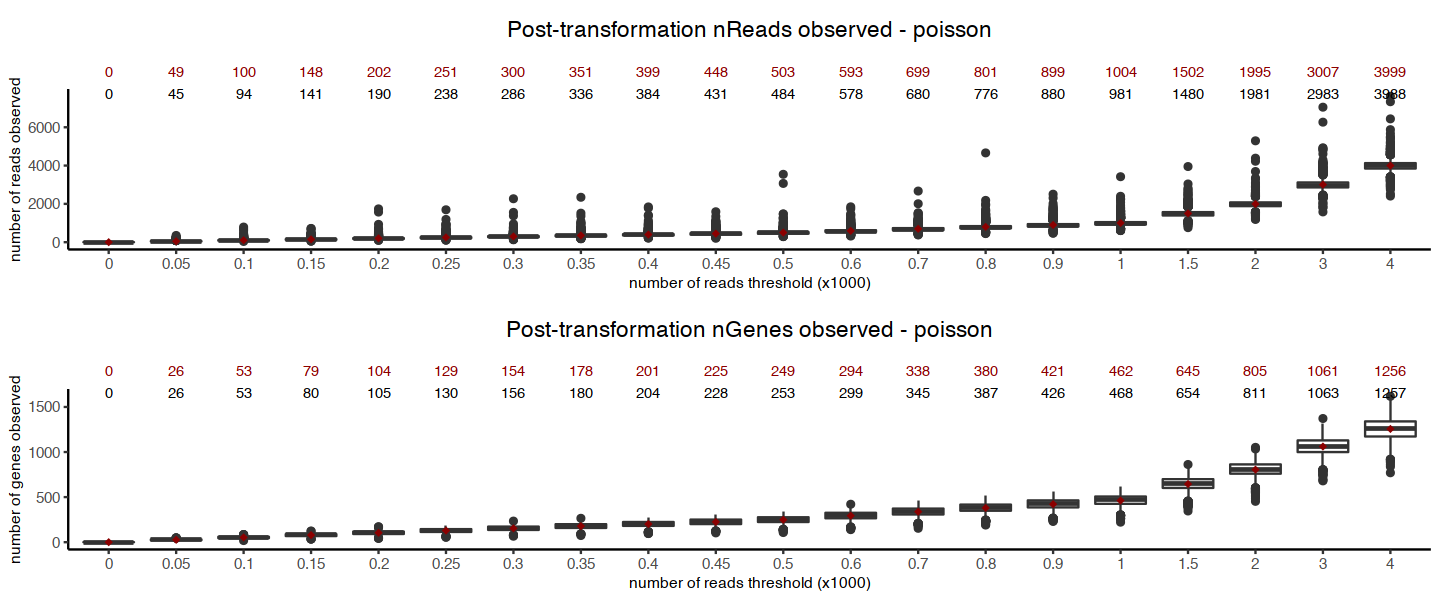

In [31]:
mean.v = -15
median.v = -13
mean.median.h = 22
# show reads and genes distribution, mean and median 
statplot <- function(method){
    if (method == 'floor'){
        table_type <- 'reads'
        dist.reads.data <- dist.reads_floor
        dist.genes.data <- dist.genes_floor
        stats.reads.data <- stat.reads_floor
        stats.genes.data <- stat.genes_floor

        } else if (method == 'poisson'){
        table_type <- 'reads'
        dist.reads.data <- dist.reads_poisson
        dist.genes.data <- dist.genes_poisson
        stats.reads.data <- stat.reads_poisson
        stats.genes.data <- stat.genes_poisson


        } else if (method == 'non-binary'){
        table_type <- 'genes'
        dist.reads.data <- dist.reads_nonbin
        dist.genes.data <- dist.genes_nonbin
        stats.reads.data <- stat.reads_nonbin
        stats.genes.data <- stat.genes_nonbin
        }
    # reads distribution plot 
    plot1 <- ggplot(dist.reads.data, aes(as.factor(variable), value)) + 
                geom_boxplot() + 
                stat_summary(fun= mean, colour="darkred", geom="point", shape=18, size=2, show.legend=FALSE) + # mean
                geom_text(data = stats.reads.data, aes(label = Mean, y =  10), vjust= mean.v, size = 3, colour="darkred") +  # mean annotations
                geom_text(data = stats.reads.data, aes(label = median, y =  10), vjust= median.v, size = 3, colour="black") +  # median annotations 
                geom_text(x=mean.median.h , y = mean.v, label="Mean", colour="darkred", size = 3, vjust = mean.v ) +  # mean label
                geom_text(x=mean.median.h , y = median.v, label="Median", colour="black", size = 3, vjust = median.v) +  # median label

                ggtitle(paste("Post-transformation nReads observed -", method)) +
                xlab(paste('number of', table_type, 'threshold (x1000)'))  + ylab("number of reads observed") + 
                theme_classic() +
                theme(plot.title = element_text(vjust = 9, hjust = 0.5), # title centered & up to accomodate stats annotations
                    axis.title=element_text(size= 9,face="bold")) + # adjust axis label sizes
                coord_cartesian(clip = "off")

    # genes distribution plot 
    plot2 <- ggplot(dist.genes.data, aes(as.factor(variable), value)) + 
            geom_boxplot() + 
            stat_summary(fun= mean, colour="darkred", geom="point", shape=18, size=2, show.legend=FALSE) + # mean
            geom_text(data = stats.genes.data, aes(label = Mean, y =  10), vjust= mean.v, size = 3, colour="darkred") +  # mean annotations 
            geom_text(data = stats.genes.data, aes(label = median, y =  10), vjust= median.v, size = 3, colour="black") +  # median annotations 
            geom_text(x=mean.median.h , y = mean.v, label="Mean", colour="darkred", size = 3, vjust = mean.v ) +  # mean label
            geom_text(x=mean.median.h , y = median.v, label="Median", colour="black", size = 3, vjust = median.v) +  # median label
            ggtitle(paste("Post-transformation nGenes observed -", method)) +
            xlab(paste('number of', table_type, 'threshold (x1000)')) + ylab("number of genes observed") + 
            theme_classic() +
            theme(plot.title = element_text(vjust = 9, hjust = 0.5), # title centered & up to accomodate stats annotations
                axis.title=element_text(size= 9,face="bold") ) + 
            coord_cartesian(clip = "off")

    spacer <- NULL
    ggarrange(grobs = spacer, plot1, spacer, plot2, ncol = 1, nrow = 4, heights=c(20, 100, 20, 100), widths = c(200), legend ='top') 
}
plot3 <- statplot('poisson')

plot3
options(repr.plot.width=12, repr.plot.height=5)


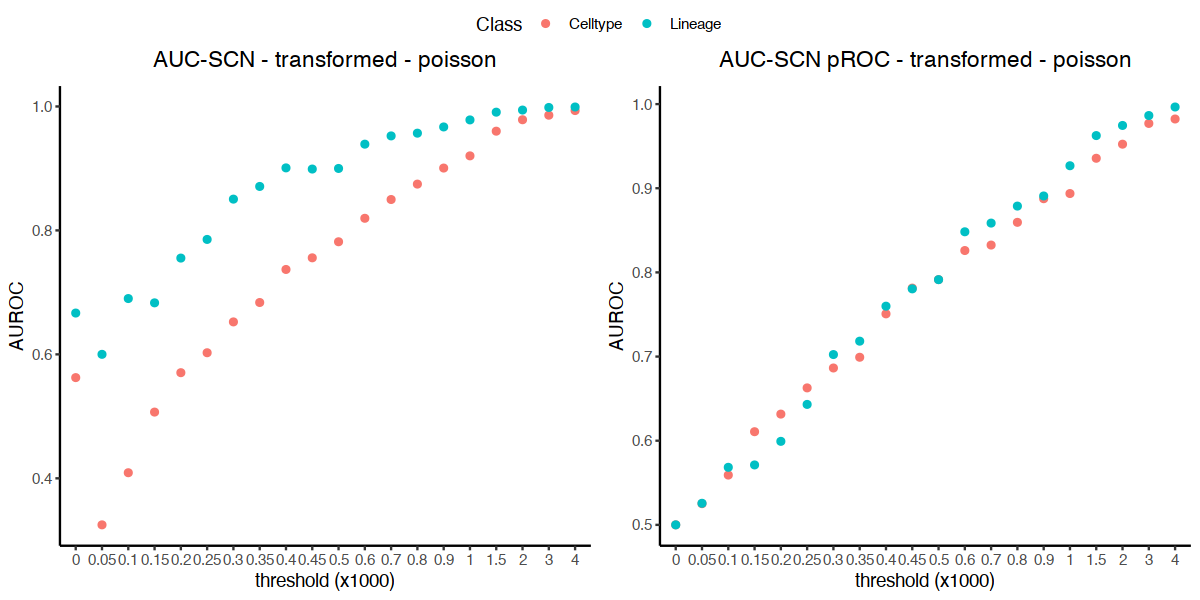

In [72]:
options(repr.plot.width=10, repr.plot.height=5)

method = 'poisson'
plot1 <- ggplot(perf.SCN[perf.SCN$method == method,], aes(as.factor(threshold), as.numeric(AUC_SCN)  )) + 
            geom_point(aes(color = as.factor(class))) + 
            ggtitle(paste('AUC-SCN', "transformed", method, sep =' - ')) +
            xlab("threshold (x1000)") + ylab("AUROC")+ labs(color='Class')  +
            theme_classic() + 
            theme(plot.title = element_text(vjust = 2, hjust = 0.5)) # center plot title


plot2 <- ggplot(perf.SCN[perf.SCN$method == method,], aes(as.factor(threshold), as.numeric(AUC_pROC)  )) + 
            geom_point(aes(color = as.factor(class))) + 
            ggtitle(paste('AUC-SCN pROC', "transformed", method, sep =' - ')) +
            xlab("threshold (x1000)") + ylab("AUROC")+ labs(color='Class')  +
            theme_classic() + 
            theme(plot.title = element_text(vjust = 2, hjust = 0.5)) # center plot title

ggarrange(grobs = plot1, plot2, ncol = 2, nrow = 1, heights=c(400, 20, 400), widths = c(200,  200), common.legend = TRUE)


In [73]:
# Figure 3

setwd('/Users/ibishara/Desktop/FELINE_C1/')

# packages
library(data.table)
library(tidyverse)
library(ggridges)
library(ggpubr)
library(qs)
library(factoextra)


# data
# meta_raw <- read.table('raw/FELINE_C1_raw_singler_metadata.txt', sep='\t') # combined raw metadata of FELINE-C1. Generated by IB. Not used in this analysis. 

# hpca_anno_raw <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/raw/SingleR/hpca/FELINE_C1_hpca_singleR_annotations.txt', sep='auto'))[, -1] # hpca singleR annotations FELINE-C1
# metadata_post_filter <- as.data.frame(fread('/Users/ibishara/Desktop/FELINE_C1/post-filter/FEL001046_scRNA.metadata_JF.txt', sep='auto')) # Jinfeng's high quality metadata 
meta_sub_LQ <- fread('metadata_subsample_LQ.txt', sep='\t', data.table=F) # low quality subsample metadata
meta_sub_HQ <- fread('metadata_subsample_HQ.txt', sep='\t', data.table=F) # high quality subsample metadata

meta_sub <- bind_rows(meta_sub_HQ[, c('Cell', 'Percent.Mitochondria', 'nCount_RNA', 'nFeature_RNA', 'Annotation', 'Celltype', 'hpca', 'Lineage')], 
meta_sub_LQ[, c('Cell', 'nCount_RNA', 'nFeature_RNA', 'Percent.Mitochondria', 'hpca', 'Lineage') ])
# Edit to block back identification to patients 

## indexing 
# Lineage
epi.ind <- which(meta_sub$Lineage == "Epithelial_cells")
mes.ind <- which(meta_sub$Lineage == "Stromal_cells")
hem.ind <- which(meta_sub$Lineage == "Immune_cells")

# cell type
tcell.ind <- which( meta_sub$hpca == "T_cells" )
bcell.ind <- which( meta_sub$hpca == "B_cell" )
macro.ind <- which( meta_sub$hpca == "Macrophage")
fibro.ind <- which( meta_sub$hpca == "Fibroblasts")
endo.ind <- which( meta_sub$hpca == "Endothelial_cells")
bcell.ind <- which( meta_sub$hpca == "B_cell")



## setting cut-offs
## JF's cut-off for FELINE_C1: > 2000 UMI. 500 - 7000 genes 
nCount_RNA_cutoff <- 1500
new.nCount_RNA_cutoff <- 200
Expressed.Features_cutoff.min <- 500
Expressed.Features_cutoff.max <- 7000



# all.retained <- length(which(meta_sub$nCount_RNA < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA )
# epi.retained <- length(which(meta_sub$nCount_RNA[epi.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[epi.ind] )
# mes.retained <- length(which(meta_sub$nCount_RNA[mes.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[mes.ind] )
# hem.retained <- length(which(meta_sub$nCount_RNA[hem.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[hem.ind] )

# tcell.retained <- length(which(meta_sub$nCount_RNA[tcell.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[tcell.ind] )
# macro.retained <- length(which(meta_sub$nCount_RNA[macro.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[macro.ind] )
# fibro.retained <- length(which(meta_sub$nCount_RNA[fibro.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[fibro.ind] )
# endo.retained <- length(which(meta_sub$nCount_RNA[endo.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[endo.ind] )
# bcell.retained <- length(which(meta_sub$nCount_RNA[bcell.ind] < nCount_RNA_cutoff)) / length(meta_sub$nCount_RNA[bcell.ind] )


pre.retained.all <- length(which(meta_sub$nCount_RNA > nCount_RNA_cutoff))
post.retained.all <- length(which(meta_sub$nCount_RNA < nCount_RNA_cutoff & meta_sub$nCount_RNA > new.nCount_RNA_cutoff))

pre.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] > nCount_RNA_cutoff))
post.retained.epi <- length(which(meta_sub$nCount_RNA[epi.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[epi.ind] > new.nCount_RNA_cutoff))

pre.retained.mes <- length(which(meta_sub$nCount_RNA[mes.ind] > nCount_RNA_cutoff))
post.retained.mes <- length(which(meta_sub$nCount_RNA[mes.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[mes.ind] > new.nCount_RNA_cutoff))

pre.retained.hem <- length(which(meta_sub$nCount_RNA[hem.ind] > nCount_RNA_cutoff))
post.retained.hem <- length(which(meta_sub$nCount_RNA[hem.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[hem.ind] > new.nCount_RNA_cutoff))


pre.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] > nCount_RNA_cutoff))
post.retained.fibro <- length(which(meta_sub$nCount_RNA[fibro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[fibro.ind] > new.nCount_RNA_cutoff))

pre.retained.bcell <- length(which(meta_sub$nCount_RNA[bcell.ind] > nCount_RNA_cutoff))
post.retained.bcell <- length(which(meta_sub$nCount_RNA[bcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[bcell.ind] > new.nCount_RNA_cutoff))

pre.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] > nCount_RNA_cutoff))
post.retained.tcell <- length(which(meta_sub$nCount_RNA[tcell.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[tcell.ind] > new.nCount_RNA_cutoff))

pre.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] > nCount_RNA_cutoff))
post.retained.macro <- length(which(meta_sub$nCount_RNA[macro.ind] < nCount_RNA_cutoff & meta_sub$nCount_RNA[macro.ind] > new.nCount_RNA_cutoff))



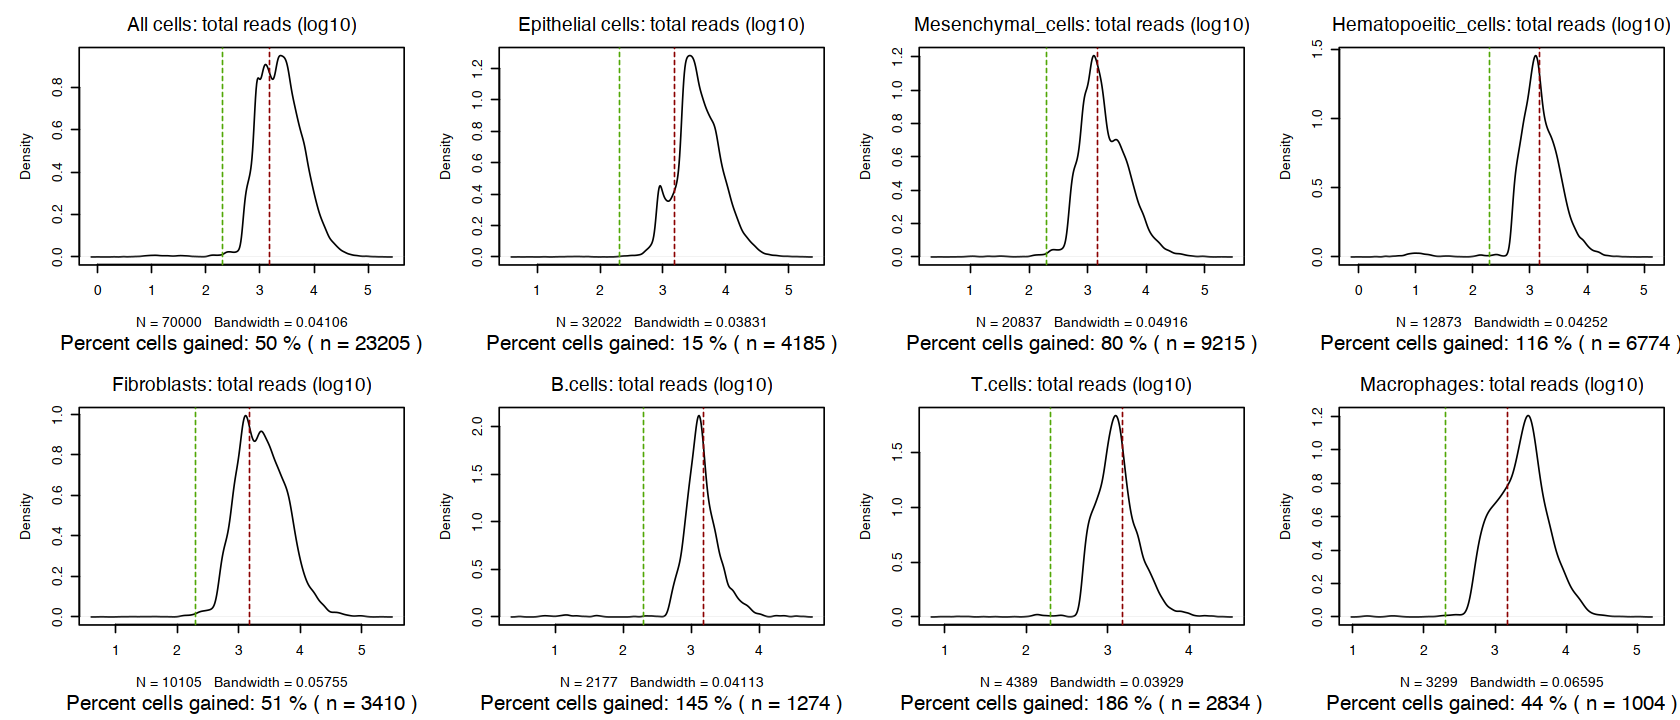

In [74]:

options(repr.plot.width=14, repr.plot.height=6)

title.size <- 1.4
lab.size <- 1.0
sub.size <- 1.4


## Plot number of reads and genes by lineage
par(mfrow=c(2,4), mar=c(6,5,3,1))

plot(main = "All cells: total reads (log10)", density(log10(meta_sub$nCount_RNA)), , cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.all/pre.retained.all),'%', '( n =', post.retained.all, ')' ))  # subtitle

plot(main = "Epithelial cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[epi.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.epi/pre.retained.epi),'%', '( n =', post.retained.epi, ')' ))  # subtitle

plot(main = "Stromal_cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[mes.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.mes/pre.retained.mes),'%', '( n =', post.retained.mes, ')' ))  # subtitle

plot(main = "Immune_cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[hem.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.hem/pre.retained.hem),'%', '( n =', post.retained.hem, ')' ))  # subtitle

plot(main = "Fibroblasts: total reads (log10)", density(log10(meta_sub$nCount_RNA[fibro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.fibro/pre.retained.fibro),'%', '( n =', post.retained.fibro, ')' ))  # subtitle

plot(main = "B.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[bcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.bcell/pre.retained.bcell),'%', '( n =', post.retained.bcell, ')' ))  # subtitle

plot(main = "T.cells: total reads (log10)", density(log10(meta_sub$nCount_RNA[tcell.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.tcell/pre.retained.tcell),'%', '( n =', post.retained.tcell, ')' ))  # subtitle

plot(main = "Macrophages: total reads (log10)", density(log10(meta_sub$nCount_RNA[macro.ind])), cex.main = title.size, cex.lab = lab.size, cex.sub= sub.size); abline(v=log10(nCount_RNA_cutoff), lty=2, col="darkred"); abline(v=log10(new.nCount_RNA_cutoff), lty=2, col="#51a706")
mtext(line= -19.2, adj=0.5, cex=1, paste('Percent cells gained:', round(100*post.retained.macro/pre.retained.macro),'%', '( n =', post.retained.macro, ')' ))  # subtitle

# dev.off()




Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 980 features requested have zero variance (running reduction without them): FAM138A, OR4F5, OR4F16, LINC01346, HES3, AADACL3, PRAMEF12, PRAMEF1, LINC01784, PRAMEF11, HNRNPCL1, PRAMEF2, PRAMEF4, PRAMEF10, PRAMEF7, PRAMEF6, PRAMEF27, PRAMEF25, HNRNPCL2, PRAMEF26, HNRNPCL4, PRAMEF9, PRAMEF13, PRAMEF18, PRAMEF5, PRAMEF8, PRAMEF33, PRAMEF15, PRAMEF14, PRAMEF19, PRAMEF17, PRAMEF20, RSC1A1, LINC01783, ALDH4A1, MICOS10, LINC01757, TMEM35B, OXCT2, P3R3URF, CDCP2, CYB5RL, LINC01758, LINC01140, LINC01650, ADORA3, LINC02799, IGKV1OR1-1, PPIAL4F, PPIAL4D, HIST2H3A, CRCT1, LCE3E, LCE3D, KPRP, LCE6A, SPRR4, SPRR1B, SPRR2A, SPRR2B, SPRR2E, SPRR2F, SPRR2G, LELP1, PRR9, S100A7L2, S100A3, OR10X1, OR6K6, OR6N2, OR10J1, OR10J5, APCS, SNHG28, VSIG8, PIGM, GPR52, KIAA1614-AS1, CFHR1, CFHR4, SPATA17-AS1, SPHAR, LINC01682, LINC01737, CHRM3-AS1, ZNF695, OR2C3, OR14A2, OR2M5, OR2T

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30699
Number of edges: 1073669

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9918
Number of communities: 24
Elapsed time: 3 seconds


19:12:31 UMAP embedding parameters a = 0.9922 b = 1.112

19:12:31 Read 30699 rows and found 20 numeric columns

19:12:31 Using Annoy for neighbor search, n_neighbors = 30

19:12:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:12:34 Writing NN index file to temp file /var/folders/pc/_5h71vy91gjdwx_d5z13bcb80000gp/T//Rtmp1B9X0S/file1334dbc1ebf2

19:12:34 Searching Annoy index using 1 thread, search_k = 3000

19:12:42 Annoy recall = 100%

19:12:43 Commencing smooth kNN distance calibration using 1 thread

19:12:44 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

19:12:44 Initializing from PCA

19:12:44 PCA: 2 components explained 40.97% variance

19:12:44 Commencing optimization for 200 epochs, with 1265010 positive edges

19:

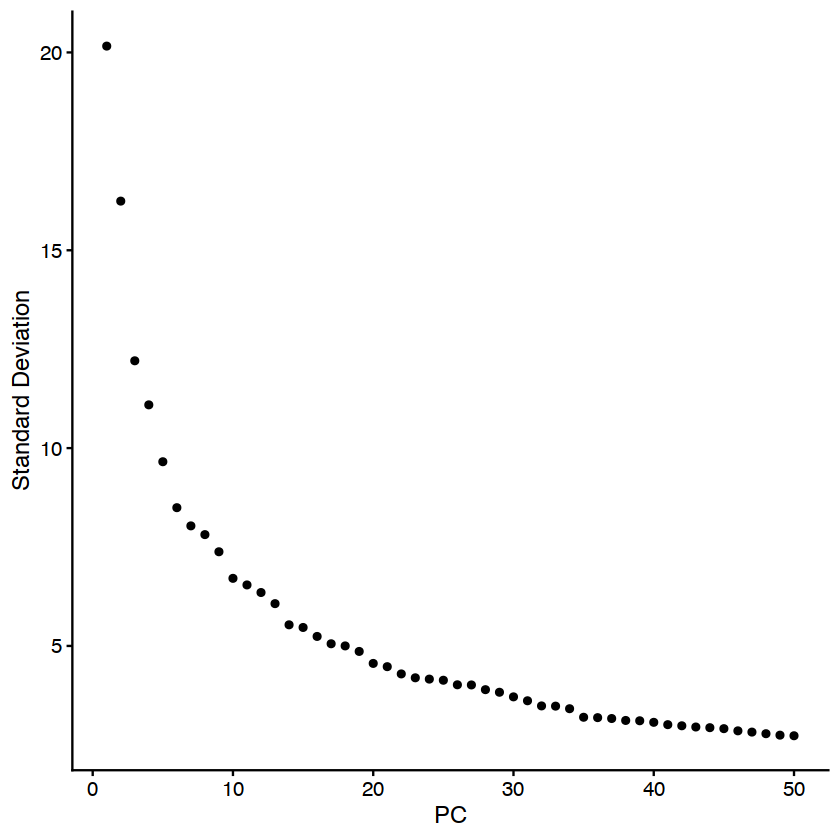

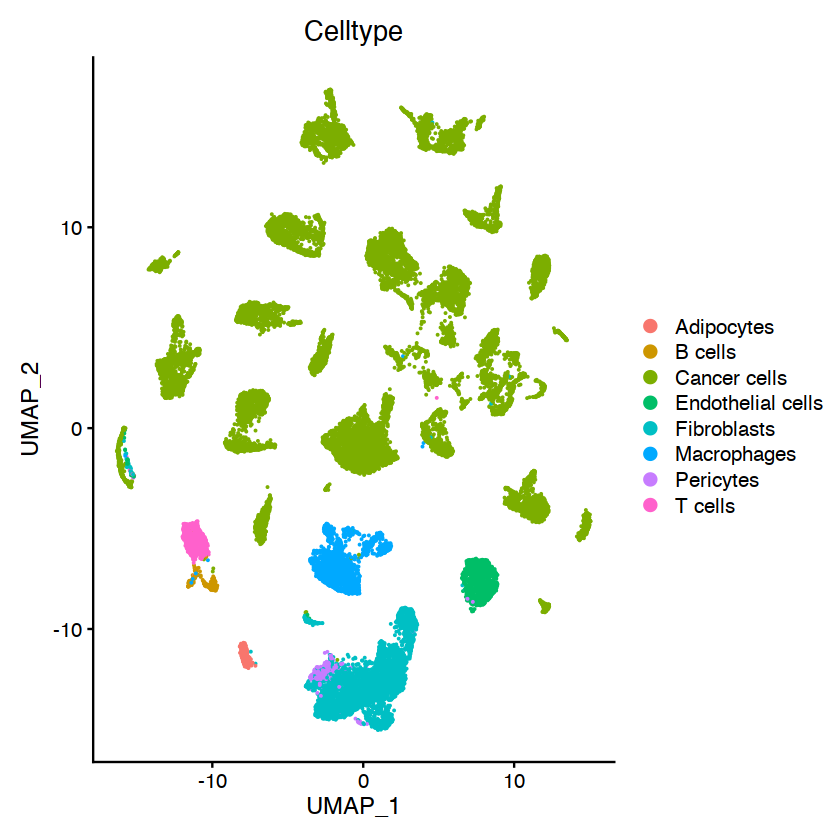

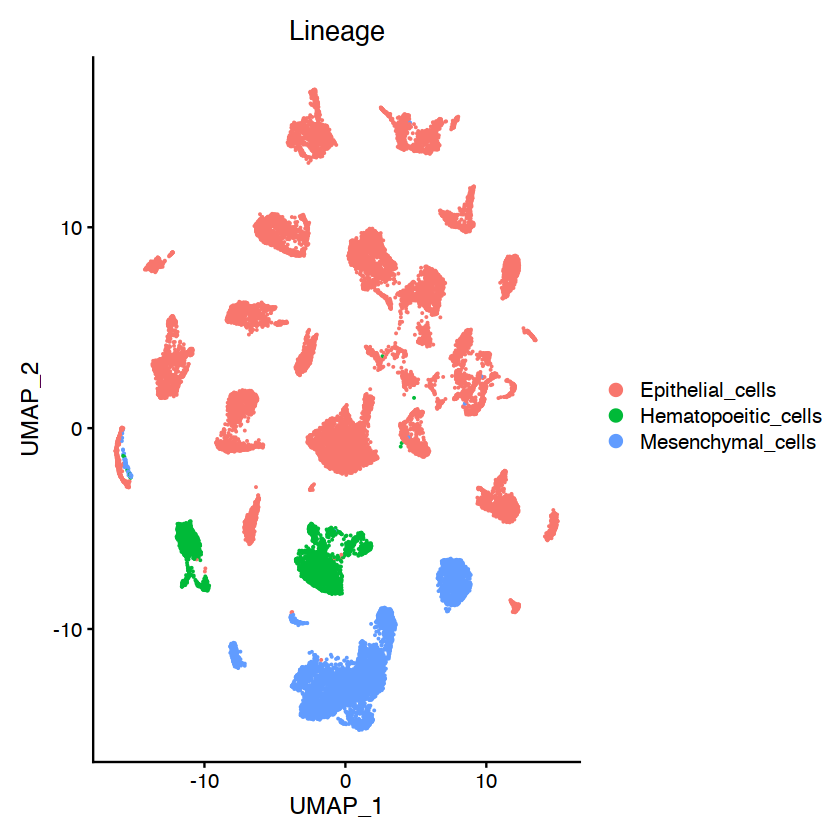

In [21]:
library(qs)
library(Seurat)

## Generate UMAP for untransformed HQ
seu_HQ <- qread(file = "seu_HQ.qs")
seu_HQ <- subset(x = seu_HQ, subset = Celltype != "Normal epithelial cells")   ## Removes normal epithelial cells. Genes unique to normal epi cells are removed from analysis downstream
seu_HQ <- subset(seu_HQ, subset = nCount_RNA < 15000 ) 

## Normalize and scale 
seu_HQ <- NormalizeData(seu_HQ)
genes <- rownames(seu_HQ)
seu_HQ <- ScaleData(seu_HQ, features = genes)
seu_HQ <- RunPCA(seu_HQ, features = genes)
ElbowPlot(seu_HQ, ndims = 50)

## Cell clustering
seu_HQ <- FindNeighbors(seu_HQ, dims = 1:20) 
seu_HQ <- FindClusters(seu_HQ, resolution = 0.1)

## UMAP
seu_HQ <- RunUMAP(seu_HQ, dims = 1:20)
DimPlot(seu_HQ, reduction = "umap", group.by = 'Celltype') 
DimPlot(seu_HQ, reduction = "umap", group.by = 'Lineage') 

Cancer cells : 21051 
Fibroblasts : 4595 
Endothelial cells : Category Endothelial cells has 1222 samples. Note this category has a samller number than ncells. 1222 
Adipocytes : Category Adipocytes has 284 samples. Note this category has a samller number than ncells. 284 
T cells : Category T cells has 727 samples. Note this category has a samller number than ncells. 727 
Macrophages : Category Macrophages has 2194 samples. Note this category has a samller number than ncells. 2194 
Pericytes : Category Pericytes has 321 samples. Note this category has a samller number than ncells. 321 
B cells : Category B cells has 305 samples. Note this category has a samller number than ncells. 305 


Warning message:
“The following arguments are not used: row.names”
Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 4984 features requested have zero variance (running reduction without them): MIR1302-2HG, FAM138A, OR4F5, OR4F29, OR4F16, FAM87B, FAM41C, RNF223, TMEM88B, CALML6, HES5, ACTRT2, CCDC27, LINC01346, LINC01345, LINC02780, LINC01777, LINC01646, LINC02781, LINC02782, LINC00337, HES3, TAS1R1, LINC01672, LINC01714, CA6, SLC2A7, PIK3CD-AS1, CENPS-CORT, TARDBP, DISP3, LINC01647, NPPB, AADACL4, AADACL3, C1orf158, PRAMEF12, PRAMEF1, LINC01784, PRAMEF11, HNRNPCL1, PRAMEF2, PRAMEF4, PRAMEF10, PRAMEF7, PRAMEF6, PRAMEF27, HNRNPCL3, PRAMEF25, HNRNPCL2, PRAMEF26, HNRNPCL4, PRAMEF9, PRAMEF13, PRAMEF18, PRAMEF5, PRAMEF8, PRAMEF33, PRAMEF15, PRAMEF14, PRAMEF19, PRAMEF17, PRAMEF20, CTRC, CELA2A, CELA2B, RSC1A1, TMEM82, FAM131C, ARHGEF19-AS1, CPLANE2, LINC01783, PADI1, PADI4, PADI6, RCC2-AS1, ACTL8, LINC01654, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5517
Number of edges: 194413

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9713
Number of communities: 6
Elapsed time: 0 seconds


19:07:06 UMAP embedding parameters a = 0.9922 b = 1.112

19:07:06 Read 5517 rows and found 10 numeric columns

19:07:06 Using Annoy for neighbor search, n_neighbors = 30

19:07:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:07:07 Writing NN index file to temp file /var/folders/pc/_5h71vy91gjdwx_d5z13bcb80000gp/T//Rtmp1B9X0S/file1334d396b547e

19:07:07 Searching Annoy index using 1 thread, search_k = 3000

19:07:08 Annoy recall = 100%

19:07:09 Commencing smooth kNN distance calibration using 1 thread

19:07:09 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

19:07:09 Initializing from PCA

19:07:09 PCA: 2 components explained 35.51% variance

19:07:09 Commencing optimization for 500 epochs, with 223160 positive edges

19:0

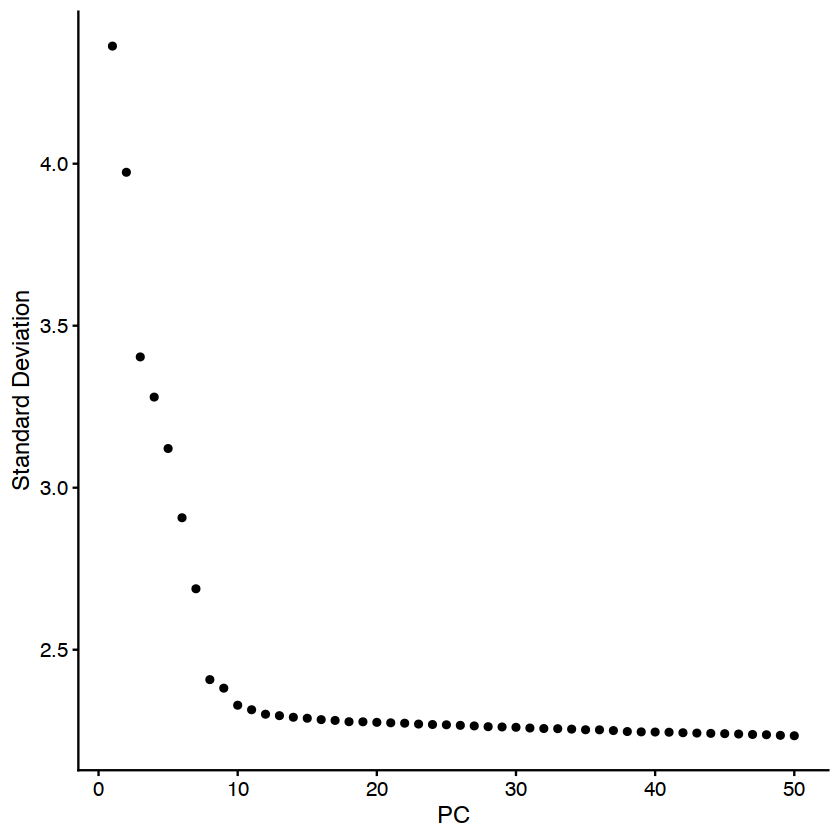

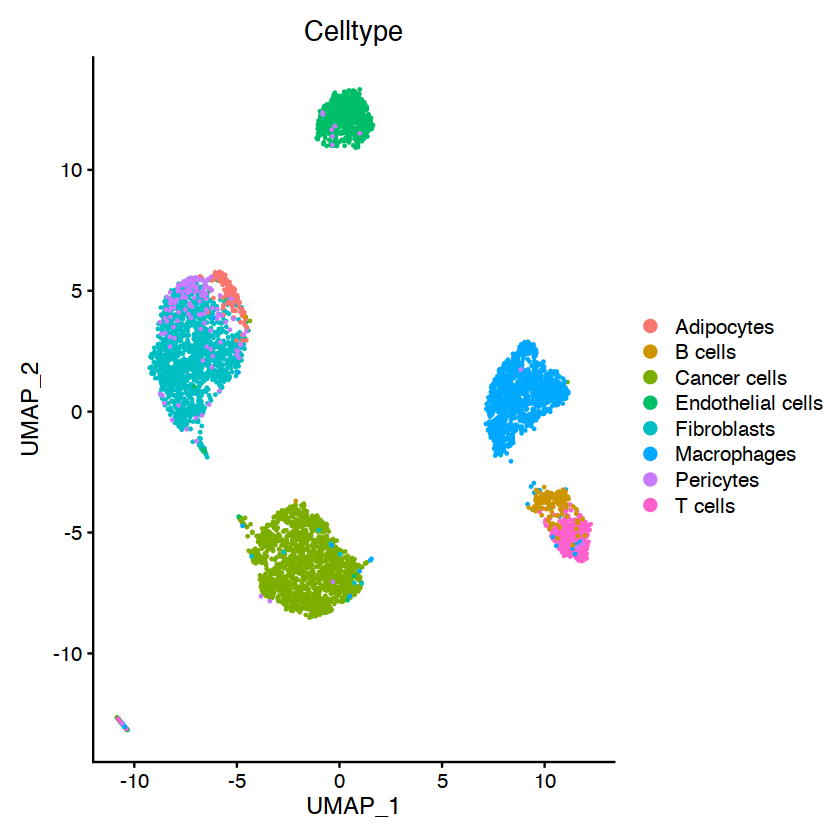

In [20]:
## Temp ##
library(qs)
library(Seurat)
library(singleCellNet)

setwd('/Users/ibishara/Desktop/FELINE_C1/')

seu_HQ <- qread(file = "seu_HQ.qs")
seu_HQ <- subset(x = seu_HQ, subset = Celltype != "Normal epithelial cells")   ## Removes normal epithelial cells. Genes unique to normal epi cells are removed from analysis downstream
seu_HQ <- subset(seu_HQ, subset = nCount_RNA < 15000 ) 
##


red.reads <- function(x, y){
    x <- round(x * rpois(n=length(x), lambda=y/sum(x)))
    return(x)
    }

meta <- seu_HQ@meta.data
seu.HQ.counts <- GetAssayData(seu_HQ, assay = "RNA")

# Split 50 / 50 
ncells <- 3000
class <- 'Celltype'
i <- 400
stList = splitCommon(sampTab = meta, ncells = ncells, dLevel = class) # At certain thresholds, there's not enough remaining cells for training 
stSub = stList[[1]]
stTrain = stSub[sample(nrow(stSub), round(nrow(stSub)/2)), ]
stTest = stSub[! rownames(stSub) %in% rownames(stTrain) ,]
counts = seu.HQ.counts[ , rownames(stTest)]

transformed <- apply(X = counts, MARGIN = 2, FUN = red.reads, y = i) # run 2nd function to reduce the number of count per cell above threshold. iterates over columns (cells)
meta_transformed <- meta[colnames(transformed), ]
seu_HQ_transformed <- CreateSeuratObject(counts= transformed, min.features= 0, min.cells = 0, names.delim= "_", meta.data= meta_transformed) 


# seu_HQ_transformed <- merge(seu_HQ, y = seu_HQ_transformed, add.cell.ids = c("untrans", "trans"))




## Normalize and scale 
seu_HQ_transformed <- NormalizeData(seu_HQ_transformed)
genes <- rownames(seu_HQ_transformed)
seu_HQ_transformed <- ScaleData(seu_HQ_transformed, features = genes)
seu_HQ_transformed <- RunPCA(seu_HQ_transformed, features = genes)
ElbowPlot(seu_HQ_transformed, ndims = 50)

## Cell clustering
seu_HQ_transformed <- FindNeighbors(seu_HQ_transformed, dims = 1:10) 
seu_HQ_transformed <- FindClusters(seu_HQ_transformed, resolution = 0.1)

## UMAP
seu_HQ_transformed <- RunUMAP(seu_HQ_transformed, dims = 1:10)
DimPlot(seu_HQ_transformed, reduction = "umap", group.by = class) 
